This notebook introduces the problem addressed in this paper:

 - localizating an object in a large image
 - foveation
 - action (saccade)
 

In [1]:
#%run 0_parameters.ipynb

In [2]:
from where import Where
from what import WhatNet
from retina import Retina
import torch
import torch.nn.functional as F

In [3]:
import matplotlib.pyplot as plt
import numpy as np
import os

In [4]:
from main import init
#args = init(filename='debug')
#args = init(filename='../data/2019-03-19_bis')
#args = init(filename='../data/2020-02-02')
args = init(filename='../data/2019-06-13')

#args = init(filename='../data/2019-03-29')

args.save_model = True
period = 10
args.sf_0 = 1/period
args.B_sf = 1/period
contrast = None
args.contrast = contrast
args.offset_std = 30

# accuracy as a function of eccentricity


In [5]:
from where import where_suffix
import os

linear = True
nb_saccades_max = 5

suffix = where_suffix(args)

In [6]:
from where import where_suffix
accuracy_mean_linear = {}
accuracy_mean_log = {}
linear=True
for contrast in (0.3, 0.5, 0.7):
    args.contrast = contrast
    suffix = where_suffix(args)
    nb_saccades_max = 5
    # print('suffix =', suffix)
    if linear:
        file_path_linear = '../data/eccentricity_accuracy_linear_{}_{}.npy'.format(suffix, nb_saccades_max)
        data = np.load(file_path_linear, allow_pickle=True)
        eccentricities_linear = data[0]
        accuracy_mean_linear[contrast] = data[1]

    else:
        file_path_log = '../data/eccentricity_accuracy_{}_{}.npy'.format(suffix, nb_saccades_max)
        data = np.load(file_path_log, allow_pickle=True)
        eccentricities_log = data[0]
        accuracy_mean_log[contrast] = data[1]


suffix = _0.1_0.1_1.0_0.3_30_40_6_24_10_2_1.41_128
suffix = _0.1_0.1_1.0_0.5_30_40_6_24_10_2_1.41_128
suffix = _0.1_0.1_1.0_0.7_30_40_6_24_10_2_1.41_128


In [7]:
eccentricities_linear

array([40.        , 35.55555556, 31.11111111, 26.66666667, 22.22222222,
       17.77777778, 13.33333333,  8.88888889,  4.44444444])

In [8]:
accuracy_mean_linear

{0.3: {0: array([0.093, 0.115, 0.103, 0.103, 0.131, 0.182, 0.342, 0.455, 0.528]),
  1: array([0.164, 0.234, 0.252, 0.318, 0.368, 0.397, 0.466, 0.512, 0.538]),
  2: array([0.197, 0.258, 0.341, 0.325, 0.411, 0.436, 0.47 , 0.501, 0.538]),
  3: array([0.21 , 0.261, 0.323, 0.357, 0.416, 0.438, 0.453, 0.509, 0.506]),
  4: array([0.224, 0.282, 0.326, 0.33 , 0.359, 0.444, 0.453, 0.498, 0.484]),
  5: array([0.204, 0.288, 0.319, 0.341, 0.347, 0.404, 0.462, 0.47 , 0.476])},
 0.5: {0: array([0.111, 0.105, 0.127, 0.108, 0.151, 0.306, 0.478, 0.699, 0.823]),
  1: array([0.422, 0.537, 0.566, 0.625, 0.66 , 0.717, 0.762, 0.811, 0.833]),
  2: array([0.493, 0.608, 0.649, 0.678, 0.728, 0.776, 0.78 , 0.799, 0.804]),
  3: array([0.502, 0.607, 0.657, 0.706, 0.715, 0.765, 0.79 , 0.789, 0.792]),
  4: array([0.526, 0.631, 0.649, 0.721, 0.719, 0.747, 0.791, 0.792, 0.789]),
  5: array([0.523, 0.602, 0.651, 0.686, 0.737, 0.752, 0.787, 0.78 , 0.805])},
 0.7: {0: array([0.111, 0.112, 0.102, 0.104, 0.159, 0.287, 0.532

In [9]:
colors = ('orange','blue','red','yellow','cyan','purple')
colors = ('orange','blue','blue','blue')

In [10]:
args.contrast = None
suffix = where_suffix(args)

In [11]:

def hist_plot(eccentricities, accuracy_mean, saccade_range, ax_D, colors, linear, 
              title, ylabel=False):
    if not linear:
        width = .3*np.abs(eccentricities)
    else:
        width = 4
        #width = .8*np.abs(np.gradient(eccentricities)[0])
    for num_saccade in saccade_range:
        if num_saccade <2:
            label = str(num_saccade)+' saccade'
        else:
            label = str(num_saccade)+' saccades'
        ax_D.bar(eccentricities, accuracy_mean[num_saccade], width=width, alpha = .5, label = label, color=colors[num_saccade])#yerr=accuracy_std, 
    # TODO what instead? ax_D.bar(eccentricities, accuracy_data, alpha = .5, label = 'No saccade') #accuracy_map[27,27:55])
    #ax_D.bar(eccentricities, ctl_accuracy_mean, width=width, color='orange', alpha = .7, label = 'No saccade')
    
    #ax_D.set_title('Class accuracy', fontsize = 14)
    ax_D.plot([eccentricities.min()-2, eccentricities.max()+2], [0.1]*2, ':', 
              c='k', label = 'Chance level', linewidth=3)
    ax_D.set_xlabel('Target eccentricity (pixels)', fontsize = 20)
    ax_D.set_ylim([0,1])
    if ylabel:
        ax_D.set_ylabel('Classification acuracy', fontsize = 20)
    ax_D.tick_params(labelsize=16)
    if not linear:
        ax_D.set_xscale('log')
    ax_D.set_xticks(eccentricities)
    ax_D.set_xticklabels(['%.0f' % d for  d in eccentricities], fontsize = 16)
    
    if not linear:
        ax_D.set_xlim([1.3,30])
    if linear:
        plt.legend(loc='best', fontsize = 14) #,  bbox_to_anchor=(-1.3, 1))
    ax_D.set_title(title, fontsize = 24)

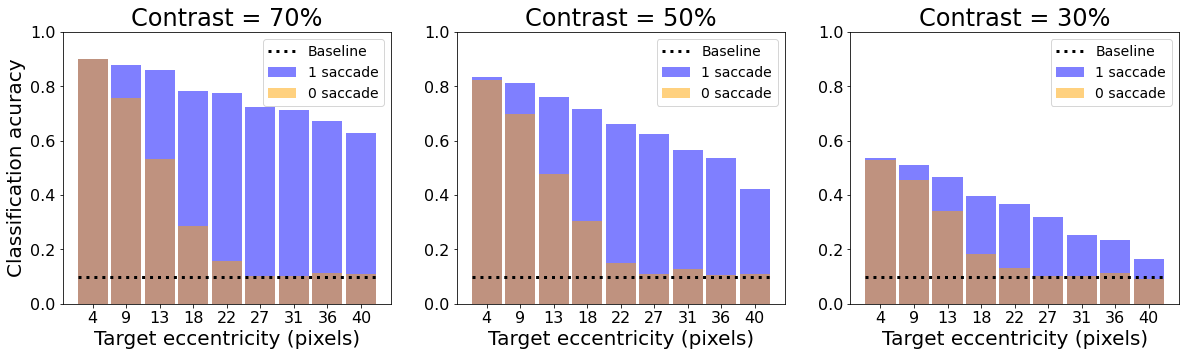

In [12]:
figwidth = 15

fig = plt.figure(figsize = (20, 5)) #figwidth/1.618))
#for saccade_range in ([1, 0], [2, 0], [3, 0]): #([1, 0], [2, 1, 0], [3, 2, 1, 0]):
for num, contrast in enumerate([0.7, 0.5, 0.3]):
    saccade_range = [1, 0]
    ylabel = num==0
    ax_D = fig.add_subplot(1,3,num+1) 
    linear = True
    hist_plot(eccentricities_linear, accuracy_mean_linear[contrast], saccade_range, 
              ax_D, colors, linear, 
              title = 'Contrast = %.0f'%(contrast*100)+'%', 
              ylabel=ylabel) #, max(saccade_range))#'Full range')
    #plt.show()

figname = '../figures/fig_results_robust_contrast'
fig.savefig(f'{figname}.pdf', bbox_inches='tight', pad_inches=0.1)

# summary


In [13]:
_ = plt.plot(fullfield.detach().numpy())

NameError: name 'fullfield' is not defined

# post-processing

In [ ]:
!convert  -density {dpi_export} {figname}.pdf {figname}.jpg
!convert  -density {dpi_export} {figname}.pdf {figname}.png
#!convert  -density {dpi_export} -resize 5400  -units pixelsperinch -flatten  -compress lzw  -depth 8 {fname}.pdf {fname}.tiff

In [ ]:
from IPython.display import Image
Image('{figname}.png'.format(figname=figname))

In [ ]:
!ls  -l {figname}*